In [1]:
from keras.models import Sequential
from keras.layers import MaxPooling1D, Conv1D, Embedding, LSTM, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from keras import optimizers

import pandas as pd
import os
import numpy as np
import re

Using TensorFlow backend.


In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [3]:
def normalize_signal(signal, min_max=False):
    """
    signal - np.array or pd.Series with signal values
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    if signal.name == 'delta':
        return signal / 180
    if min_max:
        return (signal - signal.min()) / (signal.max() - signal.min())
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [4]:
def normalize_all_signals_in_ds(one_group_ds, min_max=False):
    drop_cols = ['t'] if 't' in one_group_ds.columns else []
    for signal in one_group_ds.drop(drop_cols, axis=1):
        if signal in ['Ug', 'Pg']:
            one_group_ds[signal] = one_group_ds[signal] / one_group_ds[signal][0] - 1
        else:
            one_group_ds[signal] = normalize_signal(one_group_ds[signal], min_max)

In [5]:
oldpwd = os.getcwd()
print(oldpwd)

/home/poligon/master_degree


In [6]:
# os.chdir(oldpwd)
# os.chdir('..')
os.getcwd()

'/home/poligon/master_degree'

In [7]:
def append_signals_np_array(data_directory, signals_np_array = None, labels = None):
    drop_cols = ['Us', 'Pgt', 'Pij', 't']
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    if labels is None:
        signal_id = 0
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    else:
        signal_id = labels.id.max() + 1
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*\.csv)', filename):
                if (signals_np_array) is not None:
                    tmp_ar = pd.read_csv(filename).drop(drop_cols, axis=1)
                    normalize_all_signals_in_ds(tmp_ar)
#                     print(tmp_ar.values.T.reshape(-1, 1))
                    signals_np_array = np.append(signals_np_array, tmp_ar.values.T.reshape(1, -1), axis=0)
                else:
                    signals_np_array = pd.read_csv(filename).drop(drop_cols, axis=1)
                    normalize_all_signals_in_ds(signals_np_array)
                    signals_np_array = signals_np_array.values.T.reshape(1, -1)
#                     print(signals_np_array)
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_np_array, labels

In [8]:
# Dataset for first gen
X_train, labels_train = append_signals_np_array('./data/gen_1_25')
X_train, labels_train = append_signals_np_array('./data/gen_3_25', X_train, labels_train)
# dataset, labels = append_signals_dataset('./data/gen_1_80', dataset, labels)
# Dataset for second gen
X_val, labels_val = append_signals_np_array('./data/gen_1_80')
X_val, labels_val = append_signals_np_array('./data/gen_2_80', X_val, labels_val)
X_val, labels_val = append_signals_np_array('./data/gen_3_80', X_val, labels_val)

In [9]:
labelizer = LabelEncoder().fit(labels_train['class'])
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
    labels_df['label'] = labelizer.transform(labels_df['class'])
    labels_df.index = labels_df['id']
    labels_df.drop(columns=['id'])

In [10]:
print(X_train.shape, X_val.shape)

(101, 600) (171, 600)


In [11]:
normalize_labels(labels_train)
normalize_labels(labels_val)

In [12]:
Y_train = labels_train.label.values
Y_val = labels_val.label.values

In [13]:
# X & Y dims check
assert X_train.shape[0] == Y_train.shape[0]
assert X_val.shape[0] == Y_val.shape[0]

In [14]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_val, Y_val = shuffle(X_val, Y_val, random_state=42)

In [15]:
X_train.shape

(101, 600)

## Using fully-connected NN

In [16]:
# History data
historical_hp = pd.DataFrame(columns=['n_'])

In [254]:
# Hyperparametrs
EPOCHS = 500
n_0 = X_train.shape[1]
n_1 = 165
# n_2 = 30
n_3 = 128
n_4 = len(labelizer.classes_)
lr = 33e-4

In [265]:
model = Sequential()
model.add(Dense(n_1, input_dim=n_0,
                activation='relu',))
#                 kernel_regularizer=regularizers.l2(20e-5)))
# model.add(Dense(n_2, activation='relu'))
# model.add(Dropout(0.9))
model.add(Dense(n_3, activation='relu',))
#                 kernel_regularizer=regularizers.l2(50e-5)))
model.add(Dropout(0.6))
model.add(Dense(n_4, activation='softmax'))

optimizer = optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [266]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 165)               99165     
_________________________________________________________________
dense_77 (Dense)             (None, 128)               21248     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 3)                 387       
Total params: 120,800
Trainable params: 120,800
Non-trainable params: 0
_________________________________________________________________


In [267]:
model.predict(X_val[:10])

array([[0.3815507 , 0.30808744, 0.3103619 ],
       [0.39218527, 0.300707  , 0.30710766],
       [0.38390234, 0.3053727 , 0.31072503],
       [0.38667524, 0.3039235 , 0.30940124],
       [0.3935196 , 0.29854533, 0.30793512],
       [0.36815298, 0.31908545, 0.31276157],
       [0.3713938 , 0.319411  , 0.3091952 ],
       [0.38393927, 0.30711138, 0.30894938],
       [0.36429408, 0.32723737, 0.30846855],
       [0.36671525, 0.32480994, 0.30847478]], dtype=float32)

In [268]:
history = model.fit(X_train, Y_train,
                    epochs=EPOCHS,
                    verbose=0,
                    validation_data=(X_val, Y_val)
                   )

In [269]:
history_df = pd.DataFrame(history.history)
history_df['val_loss'] = history_df['val_loss'] / history_df['val_loss'].max()
history_df['loss'] /= history_df['loss'].max()

In [270]:
print(history_df.val_accuracy.argmax())
history_df.val_accuracy.max()

77


0.7953216433525085

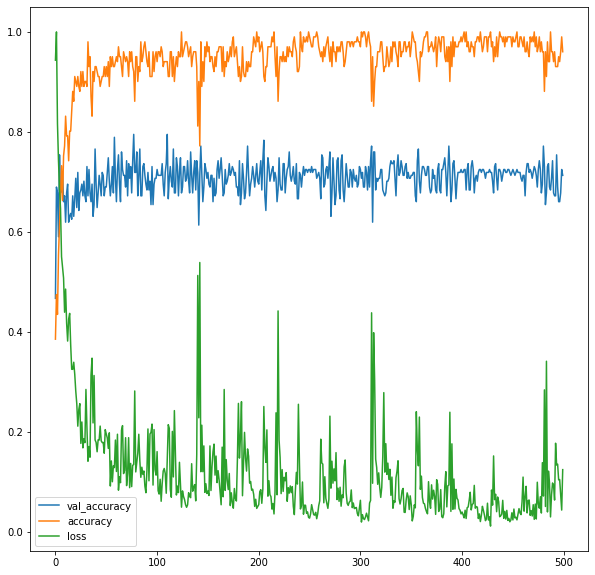

In [271]:
plt.figure(figsize=(10,10))
plt.plot(history_df.index, history_df['val_accuracy'])
plt.plot(history_df.index, history_df['accuracy'])
plt.plot(history_df.index, history_df['loss'])
# plt.axvline(history_df.val_accuracy.idxmax(), label=history_df.val_accuracy.idxmax())
# plt.axvline(history_df.loss.idxmin(), label=history_df.loss.idxmin())
# plt.plot(history.index, history['loss'])
plt.legend(['val_accuracy', 'accuracy', 'loss'])
plt.show()

In [272]:
y_pred = model.predict_classes(X_val)

In [273]:
f1_score(Y_val, y_pred, average='macro')

0.7228301565417482

In [274]:
confusion_matrix(Y_val, y_pred)

array([[50,  0,  0],
       [ 0, 30, 15],
       [ 3, 31, 42]])

In [253]:
# model.save('best_model_last.h5')

In [29]:
X_train_3d = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)

In [30]:
X_test_3d = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

NameError: name 'X_test' is not defined

In [ ]:
model = Sequential()
model.add(Conv1D(32, 10, padding='same', activation='relu', input_shape=(TIME_PERIODS,1)))
model.add(MaxPooling1D(pool_size=10))
model.add(Conv1D(64, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.metrics_names

In [ ]:
model.evaluate(X_test_3d, y_test)

In [ ]:
import keras.metrics

In [ ]:
keras.metrics.accuracy